<a href="https://colab.research.google.com/github/ajayrfhp/LearningDeepLearning/blob/main/dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install d2l

## Task
- Look into the forward and backward phase of Dropout. You can check some numpy implementation out there
- Pay attention to extra scaling operation that takes place in the forward pass. Understand, why it is there.
- Think about how backprop works for Dropout. Any data from the forward pass needs to be stored?
- Think if it is a good idea to apply dropout after a convolution layer (typically dropout is applied after fc layers).[PyTorchDropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html)
- Look into droplayer (a.k.a, StochasticDepth) and [dropblock](understand the implementation: (https://pytorch.org/vision/stable/_modules/torchvision/ops/stochastic_depth.html#stochastic_depth);
  [example usage](https://github.com/rwightman/pytorch-image-models/blob/e98c93264cde1657b188f974dc928b9d73303b18/timm/models/rexnet.py#L98-L101)
- Look into how dropout can be used to derive some [prediction confidence](https://pgg1610.github.io/blog_fastpages/python/pytorch/machine-learning/2021/01/11/Simple_Dropout.html)


## Notes

- Read dropout chapter from [D2L](https://d2l.ai/chapter_multilayer-perceptrons/dropout.html)
- Introduce noise to input to prevent overfitting.
- Noise is injected by randomly making some set of weight as 0 during input and normalizing other neurons so that mean remains unchanged.
- Mechanics
   - Forward pass
     ```
     for i in dimensions:
       h'[i] = h[i] with probability p
       h'[i] = (h[i] / 1-p) with probability 1-p

     h' should be same shape as h

     A correct mask can be achieved the transformation
     h' = mask * h
     
     ```
  
    - [My implementation](https://colab.research.google.com/drive/1c4cmicvGP2HXhUnY3NIHCGp8un3JhST_?authuser=0#scrollTo=3WY7BY1C2PeT)
  
  - Backward pass
    - The mask has be to stored for reverse mode differentiation
     ```
     dh' / dh = mask
     de / dw = (de / dh') * (dh' / dh)
     gradient_wrt_inputs = gradient_wrt_outputs * mask
     ```
    - [Someone else's implementation](https://leonardoaraujosantos.gitbook.io/artificial-inteligence/machine_learning/deep_learning/dropout_layer)


- Objects in images have clear spatial correlations. A pixel in middle of a dog is likely to have similar color, texture and structure as other pixels in the dog. Since a conv net just slides a filter over the images, different neurons in the output of conv net can be correlated with one another. The idea of a drop out is to randomly drop different parts of network for robustness against input. Even if drop out drops a certain neuron in output of a conv net, a neuron with similar features could be selected and thus overfitting is not prevented.

- Dropout can be used in test time to evaluate uncertainity of predictions.
  - A model is confident about its predictions if it is certain about its predictions especially in cases where there is noise in input.
  - Certainity of a model's prediciton can be evaluated by applying dropout in test time. Applying in dropout in test time is similar to doing inference with different trained networks.
  - Applying drop is cheaper than training 100 networks.
  - Mean, Std of predictions can be used to quantify uncertainity in prediction


- Stochastic depth
  - Residual connections have the below structure
```
H(l) = ReLU(FC(H(l-1)) + H(l-1))
```
  - During training time, the res block can be dropped with probability p.
```
H(l) = ReLU(p * FC(H(l-1)) + H(l-1))
```
  - Mechanics in pytorch
    - Row mode drop creates a noise array of n boolean values where probability of each value being 1 is 1-p. Dimensioon of noise array is (n, ) where n is number of samples in batch. Random set of input rows from batch are selected and others are zeroed
    - Batch mode intuitively creates a scalar noise that is applied over all the inputs
      - The pytorch implementation creates a noise vector for each dimension like (0.5, 0.5) if input has 2 dimensions.
  - Why
    - Very deep networks can be trained efficiently without gradients vanishing



In [ ]:
import numpy as np
from torch import nn
from d2l import torch as d2l
import torch

In [ ]:

device_type = 'cpu'
if torch.cuda.is_available():
  device_type = 'cuda'

device = torch.device(device_type)
device

device(type='cuda')

In [ ]:
def DropOut(X, p):
    """
      Args
        x - (N, d)
        p - (p)
      Returns
        x' - (N ,d)
    """
    d = X.shape[1]
    mask = np.random.sample(d)
    zero_mask = mask <= p
    one_mask = mask > p
    mask[zero_mask] = 0
    mask[one_mask] = 1
    return X * mask / (1 - p)

In [ ]:
x = np.array([[1, 2], [3, 4], [5, 6]])
DropOut(x, 0.01)

array([[1.01010101, 2.02020202],
       [3.03030303, 4.04040404],
       [5.05050505, 6.06060606]])

In [ ]:
DropOut(x, 0.1)

array([[1.11111111, 2.22222222],
       [3.33333333, 4.44444444],
       [5.55555556, 6.66666667]])

In [ ]:
DropOut(x, 0.5)

array([[ 2.,  4.],
       [ 6.,  8.],
       [10., 12.]])

In [ ]:
def TorchDropOut(X, p):
    d = X.shape[1]
    mask = torch.bernoulli(torch.ones(d) * (1-p)).float().to(device) # select ones with probability 1 - p and zeros with probability p
    return X.float() * mask / (1-p)

x = torch.tensor([[1, 2], [3, 4]]).float().to(device)
TorchDropOut(x, 0.5)

tensor([[0., 4.],
        [0., 8.]], device='cuda:0')

In [ ]:
class DropOutClassifier(d2l.Classifier):
  def __init__(self, dim=20, p=0.5, lr=0.01, use_drop_out=True):
    super().__init__()
    self.fc1 = nn.Linear(784, dim)
    self.fc2 = nn.Linear(dim, dim)
    self.fc3 = nn.Linear(dim, 10)
    self.relu = nn.ReLU()
    self.use_drop_out = use_drop_out
    self.p = p
    self.lr = lr

    pass

  def forward(self, X):
    X = X.reshape((X.shape[0], -1)).to(device)
    h = self.fc1(X.float())
    if self.training and self.use_drop_out:
      h = TorchDropOut(h, self.p)
    h = self.relu(h)
    h = self.fc2(h)
    h = self.relu(h)
    h = self.fc3(h)
    return self.relu(h)

drop_out_classifier = DropOutClassifier()
drop_out_classifier

DropOutClassifier(
  (fc1): Linear(in_features=784, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=10, bias=True)
  (relu): ReLU()
)

In [ ]:
data = d2l.FashionMNIST(batch_size=1000)

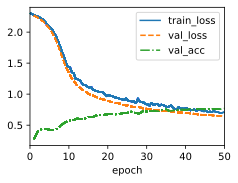

In [ ]:
model_with_dropout = DropOutClassifier(dim=100, p=0.5, lr=0.01, use_drop_out=True).to(device)
trainer = d2l.Trainer(max_epochs=50, num_gpus=1)
trainer.fit(model_with_dropout, data)

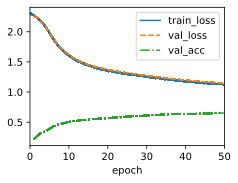

In [ ]:
model_without_dropout = DropOutClassifier(dim=100, p=0.5, lr=0.01, use_drop_out=False).to(device)
trainer_without_dropout = d2l.Trainer(max_epochs=50, num_gpus=1)
trainer_without_dropout.fit(model_without_dropout, data)

In [ ]:
def get_loss(model, data):
  model.train = False

  losses, access = [], []
  for (inputs, outputs) in data.val_dataloader():
    preds = model.forward(inputs)
    loss = model.loss(preds, outputs.to(device)).item()
    acc = model.accuracy(preds, outputs.to(device)).item()
    losses.append(loss)
    access.append(acc)

  return np.mean(np.array(losses)), np.mean(np.array(access))
get_loss(model_with_dropout, data)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(0.6419140577316285, 0.7701000332832336)

In [ ]:
get_loss(model_without_dropout, data)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(1.1442922115325929, 0.6516000330448151)